In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as smg
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import numpy as np
import warnings


## Load Data

### Migration influx

In [2]:
df_all = pd.read_csv(
    "../migration_rates/migration_rate_processed.csv", index_col=0, parse_dates=["date"]
)
df_all.set_index("date", inplace=True)
df_all["value"] = pd.to_numeric(df_all["value"], errors="coerce")
df_all["value"].fillna(
    1.0, inplace=True
)  # at least 1 person per timeframe for multiplicative seasonal decomposition

with open("../migration_rates/countries.json") as buf:
    countries = list(json.load(buf).keys())

series = {c: df_all[df_all.country == c].value for c in countries}
series["NL"]


date
2010-01-01     763.0
2010-02-01     649.0
2010-03-01     768.0
2010-04-01     772.0
2010-05-01     685.0
               ...  
2019-08-01    1076.0
2019-09-01    1130.0
2019-10-01     994.0
2019-11-01     815.0
2019-12-01     728.0
Name: value, Length: 120, dtype: float64

### Google trends

In [3]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../keywords/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../processed_data/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

keyword_ids = dataframes[countries[0]]["mean"].columns.to_list()
dataframes["NL"].head()


mean                                                         \
keyword_id          2         10         11         12         14         15   
date                                                                           
2007-01-01  12.142857   7.142857  20.714286   0.000000  19.428571  66.142857   
2007-02-01   0.000000   0.000000  56.857143   0.000000   0.000000  54.428571   
2007-03-01   0.000000  72.000000   0.000000  44.571429  13.142857  42.142857   
2007-04-01  16.571429  39.857143  22.285714   0.000000  12.285714  18.142857   
2007-05-01  11.428571   0.000000   5.857143   0.000000  18.285714   0.000000   

                                                        ...       sem  \
keyword_id         16         17         18         19  ...       114   
date                                                    ...             
2007-01-01   0.000000   0.000000  34.142857  28.142857  ...  0.746876   
2007-02-01  23.857143  36.000000   0.000000  32.000000  ...  0.918443   
2007-03-01   0.000000  36.428571   0.000000  37.285714  ...  1.445142   
2007-04-01   0.000000   0.000000   0.000000  35.285714  ...  1.148794   
2007-05-01   0.000000   0.000000  20.857143  37.857143  ...  1.078548   

                                                                        \
keyword_id       115       117       118       119       121       122   
date                                                                     
2007-01-01  4.838901  4.921838  1.269742  1.130890  1.242666  2.918391   
2007-02-01  2.542161  1.784285  2.307928  0.961858  1.360272  3.508008   
2007-03-01  5.588496  4.276180  1.737932  1.151751  0.911006  3.952094   
2007-04-01  4.495652  4.729413  1.442786  0.755929  1.127878  4.779491   
2007-05-01  6.014721  5.019011  1.397276  1.016865  0.404061  7.008256   

                                          
keyword_id       123       124       125  
date                                      
2007-01-01  1.056242  0.925820  0.480929  
2007-02-01  1.317078  1.192379  0.611678  
2007-03-01  0.972408  0.577350  0.606092  
2007-04-01  0.459221  0.737711  0.714286  
2007-05-01  0.993174  0.968904  0.649437  

[5 rows x 96 columns]

In [4]:
dfs_1y = {k: df.resample("1Y").mean() for k, df in dataframes.items()}
sers_1y = {k: df.resample("1Y").mean() for k, df in series.items()}

tmp_dfs = []

for c in countries:
    tmp_dep = (
        sers_1y[c]
        .to_frame()
        .assign(country=c)
        .assign(prev1=sers_1y[c].shift(1))
        .assign(prev2=sers_1y[c].shift(2))
        .assign(prev2_neg=-sers_1y[c].shift(2))
    )
    tmp_ind = dfs_1y[c]["mean"].shift(1)
    tmp_df = pd.concat([tmp_dep, tmp_ind], axis=1)["2010-12-31":"2019-12-31"]
    tmp_dfs.append(tmp_df)

df_panel_1y = pd.concat(tmp_dfs).sort_index()
df_panel_1y


,value,country,prev1,prev2,prev2_neg,2,10,11,12,14,...,114,115,117,118,119,121,122,123,124,125
date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,1178.500000,FR,NaN,NaN,NaN,22.666667,11.654762,24.988095,2.000000,20.964286,...,62.773810,12.976190,47.940476,74.833333,53.845238,23.773810,63.285714,54.607143,37.345238,15.702381
2010-12-31,632.916667,LV,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,43.678571,37.202381,20.630952,56.226190,75.023810,48.380952,34.321429,78.059524,40.833333,52.690476
2010-12-31,9560.500000,PL,NaN,NaN,NaN,13.821429,4.821429,13.892857,2.845238,11.297619,...,37.845238,42.202381,46.690476,48.690476,91.714286,59.654762,83.190476,91.964286,47.059524,12.785714
2010-12-31,148.750000,SI,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,47.333333,26.559524,33.333333,6.261905,80.357143,28.869048,40.714286,59.500000,40.238095,35.345238
2010-12-31,500.583333,LT,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,37.583333,43.107143,25.535714,52.821429,72.452381,54.107143,50.154762,76.880952,30.702381,45.738095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,1346.000000,GB,1269.166667,1239.916667,-1239.916667,45.511905,20.607143,53.547619,33.785714,17.500000,...,72.821429,36.964286,53.857143,46.630952,79.476190,83.845238,72.130952,70.095238,77.940476,55.035714
2019-12-31,156.666667,FI,172.666667,195.000000,-195.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55.511905,44.047619,41.773810,29.535714,83.273810,67.392857,72.107143,78.976190,74.154762,62.226190
2019-12-31,329.666667,BE,318.916667,327.916667,-327.916667,19.404762,0.000000,16.833333,0.000000,16.178571,...,54.500000,12.952381,41.678571,47.761905,83.035714,36.523810,75.333333,60.511905,87.154762,83.535714


## Evaluation functions and common variables

In [5]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import feature_selection
from sklearn import compose

t_min = "2012-12-31"
t_max = "2019-12-31"
t_split_lower = "2017-12-31"
t_split_upper = "2018-12-31"

scoring = ["neg_mean_absolute_percentage_error", "neg_root_mean_squared_error", "r2"]

# selected_countries = ["FR", "GB", "IT", "ES", "RO"]
selected_countries = countries


df_panel_1y = df_panel_1y[df_panel_1y.country.isin(selected_countries)]
dummies = pd.get_dummies(df_panel_1y["country"], drop_first=False)
dummy_cols = dummies.columns.tolist()
df_panel_1y = pd.concat([df_panel_1y, dummies], axis=1)

x = df_panel_1y.drop(columns="value")[t_min:t_max]
y = df_panel_1y["value"][t_min:t_max]

x_train = x[t_min:t_split_lower]
y_train = y[t_min:t_split_lower]
x_test = x[t_split_upper:t_max]
y_test = y[t_split_upper:t_max]

def score_cv(reg, X, y):
    scores = model_selection.cross_validate(reg, X=X, y=y, scoring=scoring)
    return pd.DataFrame(scores)

def score_test(reg, X, y):
    scores = {s: metrics.get_scorer(s)(reg, X, y) for s in scoring}
    return pd.Series(scores)

def plot_prediction(reg, X, countries=selected_countries, n_rows=6, n_cols=5, figsize=(25,25)):

    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for c, ax in zip(countries, axs.flatten()):
        df_to_plot = df_pred[df_pred.country == c]
        y_max = max(df_to_plot["pred"].max(), df_to_plot["value"].max())
        print(y_max)
        df_to_plot.plot(ax=ax, ylim=(0, y_max * 1.2))

    return fig, axs




## Naive: country average

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,test_r2
0,0.012273,0.010630,-0.232328,-2751.702411,0.162978
1,0.012129,0.009495,-0.151263,-1918.005541,0.714044
2,0.006407,0.005706,-0.147331,-1744.400767,0.923546
3,0.007215,0.004166,-0.053614,-1281.865900,0.952601
4,0.004071,0.005040,-0.174958,-1618.880025,0.928849


Mean CV score:


fit_time                                      0.008419
score_time                                    0.007007
test_neg_mean_absolute_percentage_error      -0.151899
test_neg_root_mean_squared_error          -1862.970929
test_r2                                       0.736404
dtype: float64

OOS score:


neg_mean_absolute_percentage_error      -0.148618
neg_root_mean_squared_error          -2004.236719
r2                                       0.917441
dtype: float64

1442.25
1346.0
5958.75
3042.5833333333335
19848.166666666668


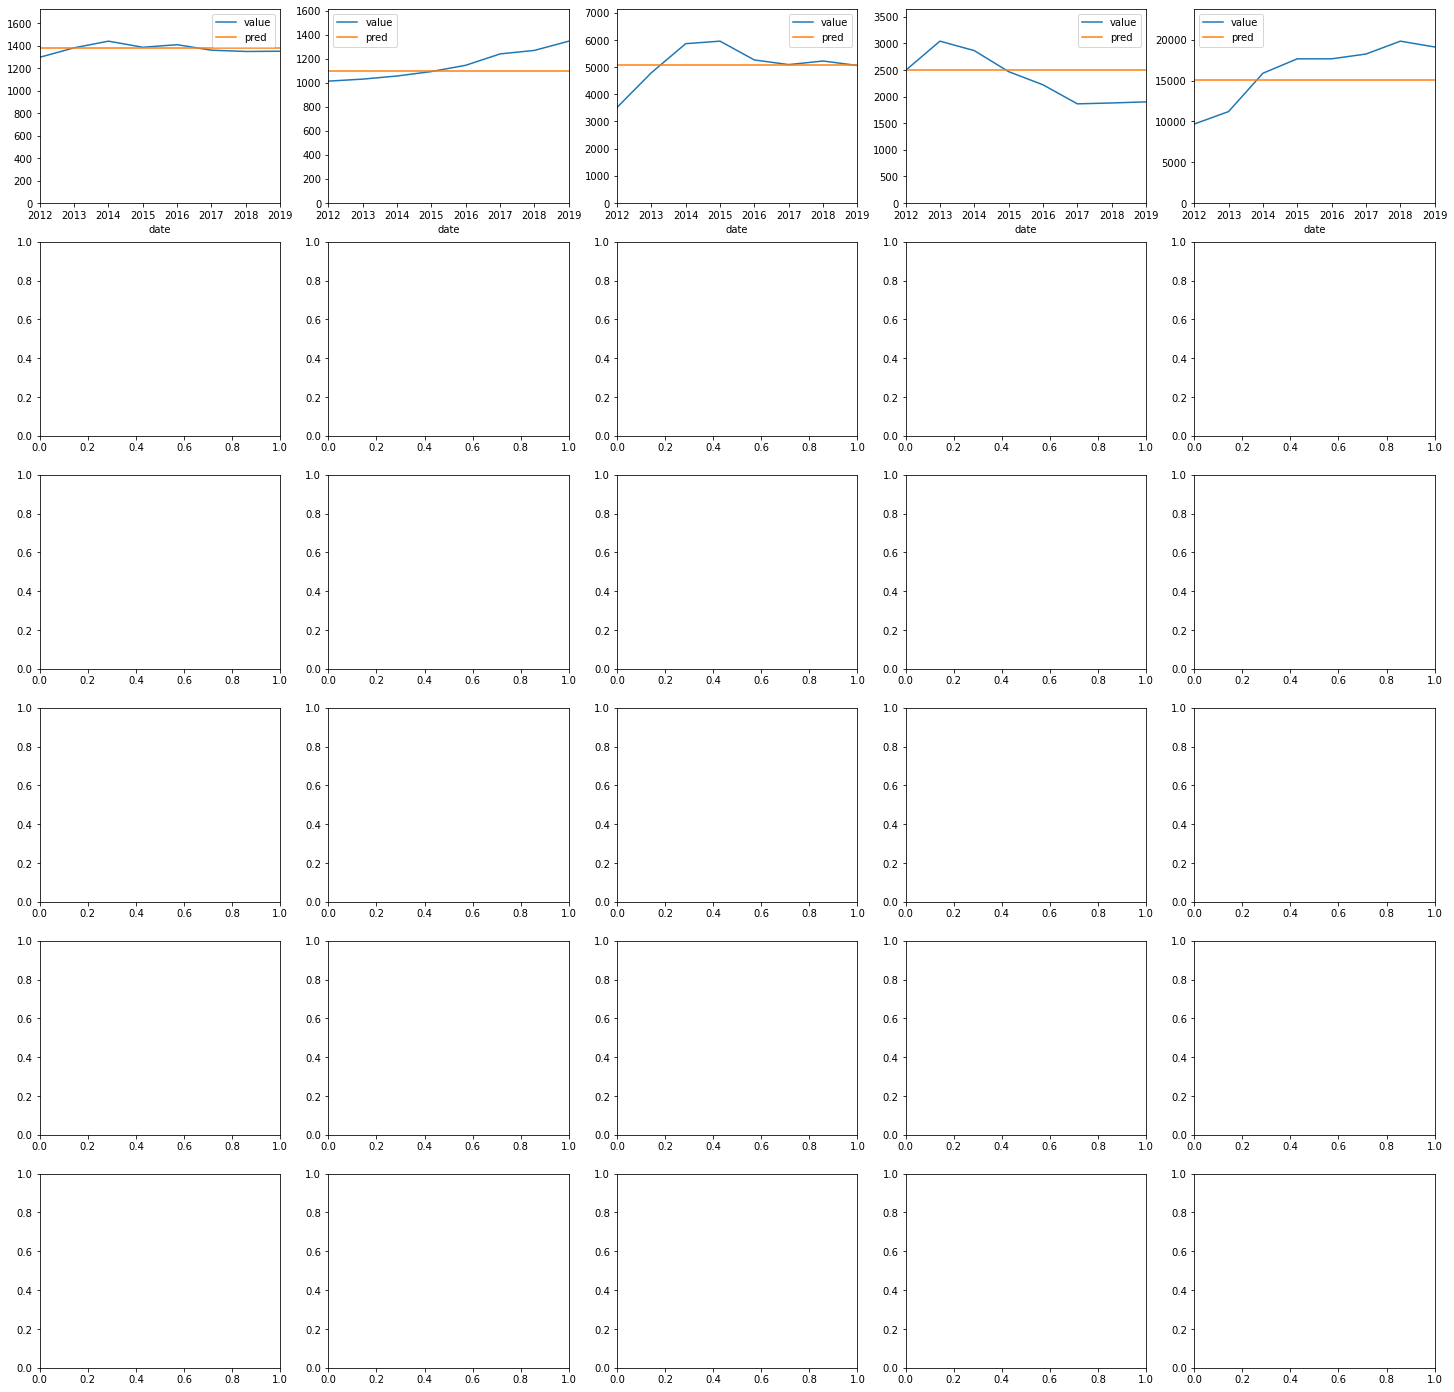

In [6]:
features = dummy_cols

reg = linear_model.LinearRegression()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])



## Autoregressive 1 and 2 years lag w. fixed effects

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,test_r2
0,0.107755,0.007407,-0.086427,-877.917372,0.914800
1,0.005922,0.004554,-0.087204,-641.832201,0.967978
2,0.005576,0.004423,-0.074009,-1389.241434,0.951509
3,0.005411,0.004356,-0.077717,-643.161370,0.988068
4,0.005000,0.004623,-0.074888,-357.303816,0.996534


Mean CV score:


fit_time                                     0.025933
score_time                                   0.005073
test_neg_mean_absolute_percentage_error     -0.080049
test_neg_root_mean_squared_error          -781.891238
test_r2                                      0.963778
dtype: float64

OOS score:


neg_mean_absolute_percentage_error     -0.031596
neg_root_mean_squared_error          -515.360637
r2                                      0.994541
dtype: float64

1450.5626354063807
1346.0
6163.610549430249
3042.5833333333335
20014.126102326707


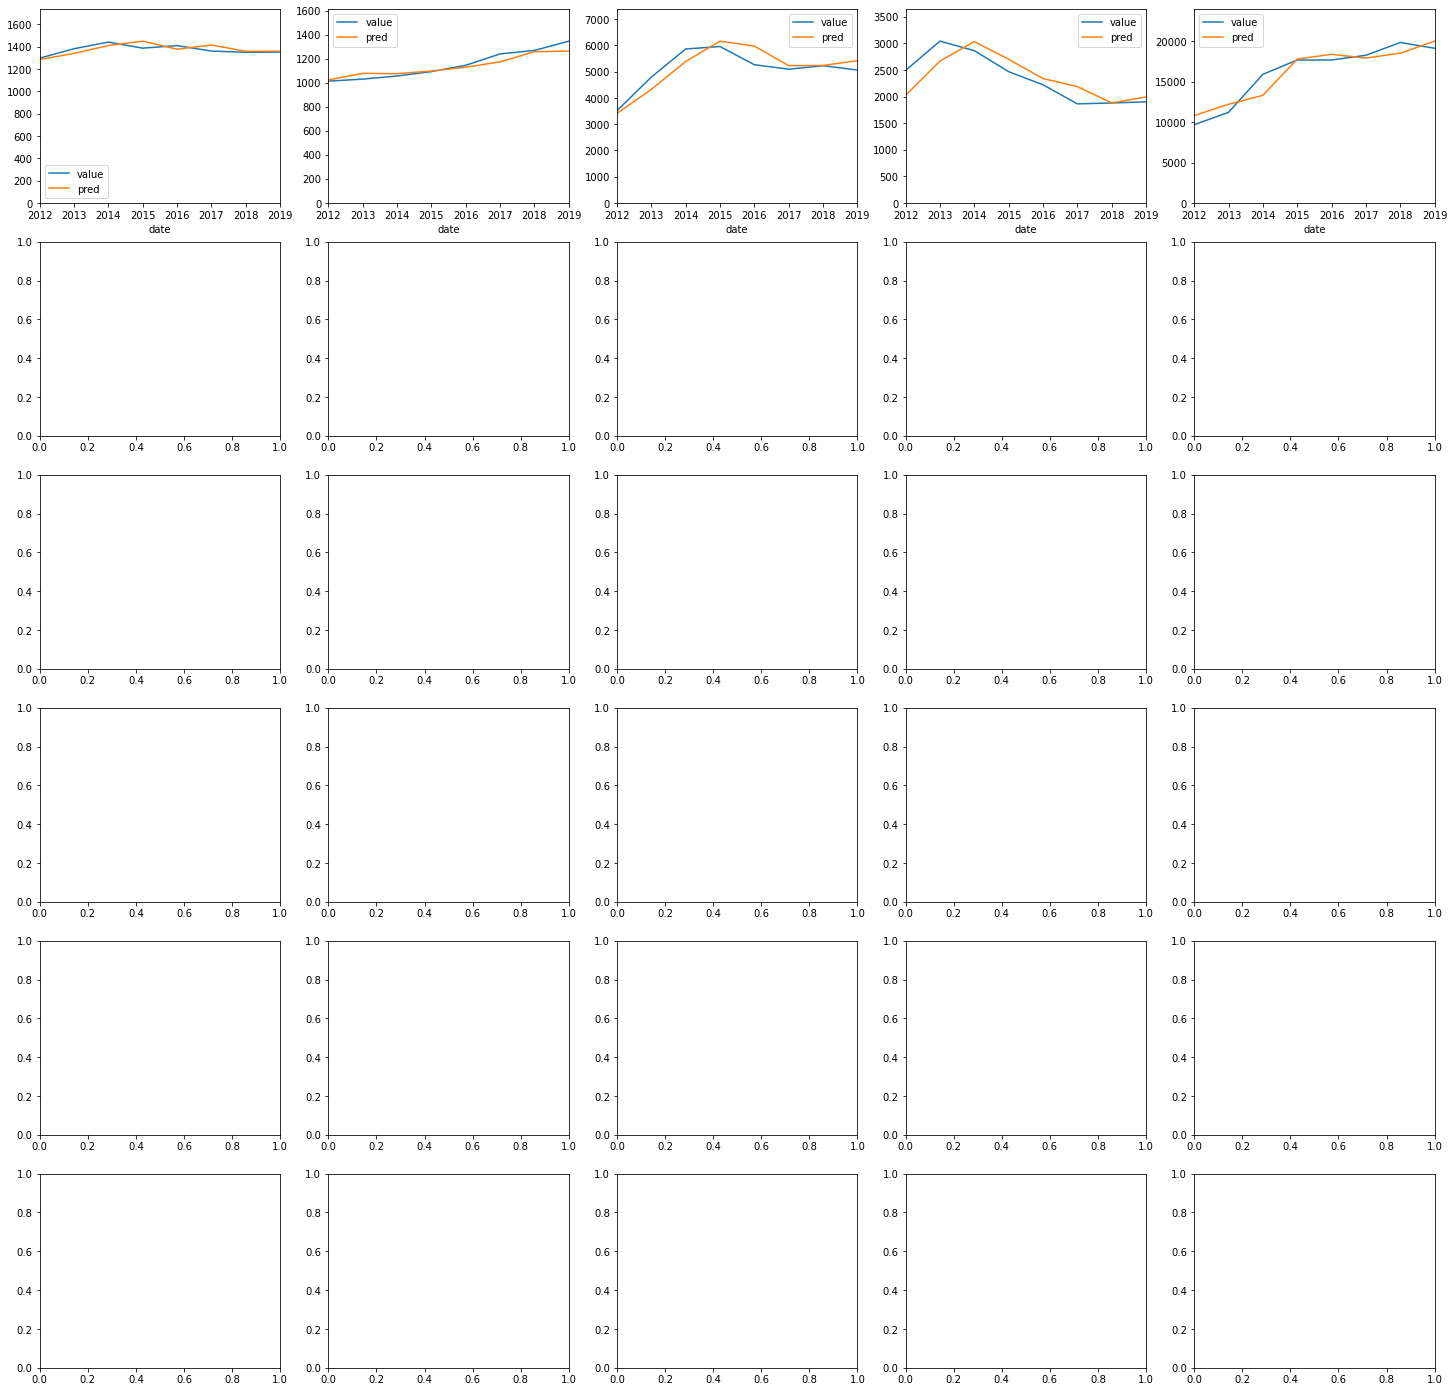

In [7]:
features = ["prev1", "prev2"] + dummy_cols

reg = linear_model.LinearRegression()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])


## LASSO fixed effects with Google Trends

/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1117269.2262206285, tolerance: 57406.10748862848
  model = cd_fast.enet_coordinate_descent(
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 458685.22629549354, tolerance: 66887.75479510994
  model = cd_fast.enet_coordinate_descent(
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1117870.9565578117, tolerance: 57406.10748862848
  model = cd_fast.enet_coordinate_descent(
/home/stei509/anaconda3/envs/eumf/lib/python3.9/s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013097,0.001292,0.006661,0.001812,0.001,-877.900382,-641.824030,-1389.238479,-643.166311,-357.302228,-781.886286,345.608936,9
1,0.009749,0.000832,0.004640,0.000295,0.01,-877.747474,-641.750492,-1389.286044,-643.210782,-357.287947,-781.856548,345.623065,8
2,0.010959,0.001503,0.005546,0.000944,0.1,-875.706039,-641.027194,-1389.829728,-643.775486,-356.594138,-781.386517,345.885939,7
3,0.012107,0.002522,0.008811,0.001905,0.2,-873.497384,-640.226561,-1390.437182,-644.391318,-355.886579,-780.887805,346.170448,6
4,0.010729,0.003587,0.006832,0.001688,0.5,-866.887692,-637.851061,-1392.323007,-646.249063,-353.776751,-779.417515,347.058822,5
5,0.007606,0.001592,0.004230,0.001216,1.0,-855.927039,-633.980882,-1395.647477,-649.379171,-350.303954,-777.047705,348.644583,4
6,0.010971,0.002740,0.004314,0.000697,2.0,-834.223686,-625.985942,-1402.831698,-655.554268,-343.527730,-772.424665,352.218034,3
7,0.007169,0.001076,0.003722,0.000375,5.0,-771.871778,-602.857339,-1429.998230,-674.295948,-326.866022,-761.177864,365.698147,2
8,0.005444,0.000571,0.003142,0.000521,10.0,-674.262542,-568.285720,-1491.027096,-707.343137,-304.829217,-749.149542,396.956022,1


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1408619.5966127021, tolerance: 57406.10748862848
  model = cd_fast.enet_coordinate_descent(


,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,test_r2
0,0.008186,0.007538,-0.093436,-674.262542,0.949743
1,0.007765,0.005253,-0.115026,-568.285720,0.974897
2,0.007242,0.009129,-0.097575,-1491.027096,0.944143
3,0.011683,0.005460,-0.098703,-707.343137,0.985568
4,0.007869,0.005336,-0.055654,-304.829217,0.997477


Mean CV score:


fit_time                                     0.008549
score_time                                   0.006543
test_neg_mean_absolute_percentage_error     -0.092079
test_neg_root_mean_squared_error          -749.149542
test_r2                                      0.970366
dtype: float64

OOS score:


neg_mean_absolute_percentage_error     -0.043163
neg_root_mean_squared_error          -532.675789
r2                                      0.994168
dtype: float64

1515.7273779594982
1363.645823832062
6200.690310634031
3042.5833333333335
20271.6879060013
LASSO Coefficients:
prev1           1.138971
prev2_neg       0.315440
ES             42.748112
FR              0.000000
GB              0.000000
IT            722.732708
RO           3118.727938


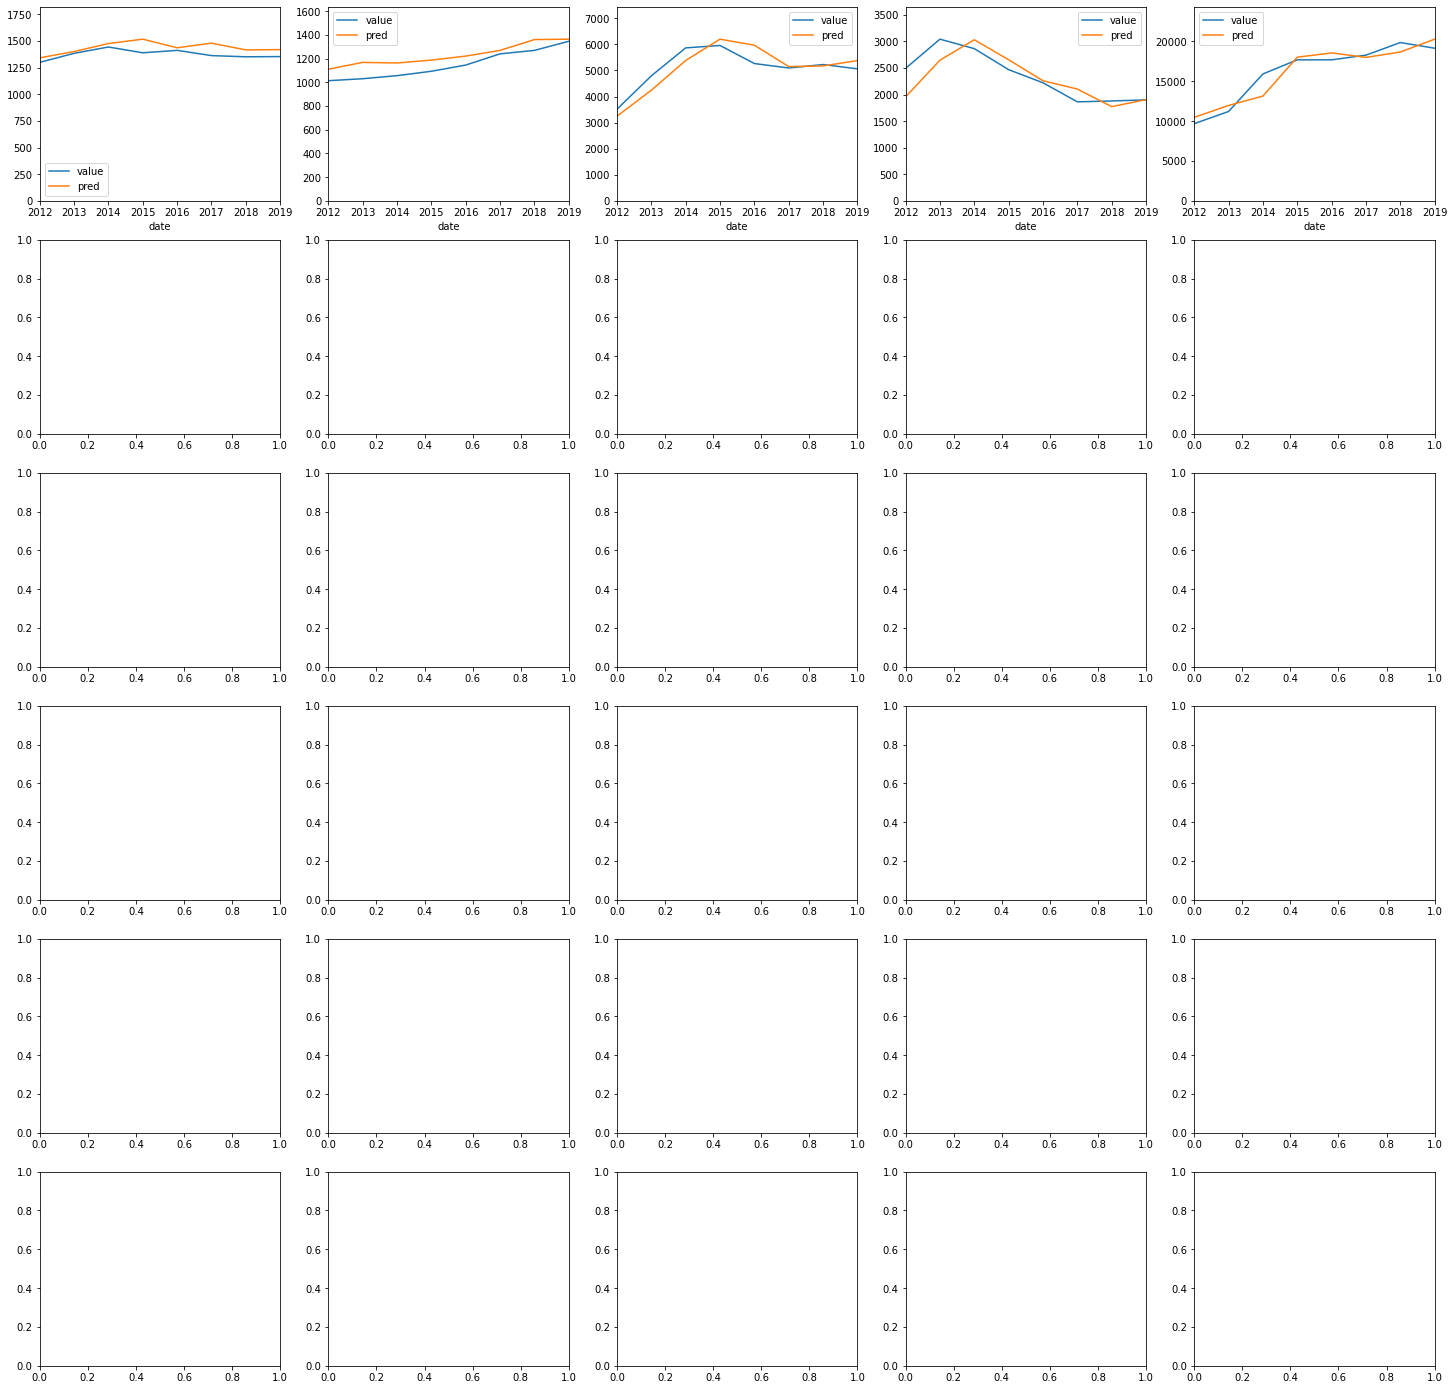

In [11]:
features = ["prev1", "prev2_neg"] + keyword_ids + dummy_cols

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.Lasso(positive=True, normalize=False)
params = {
    "alpha": [0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).to_string())



/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1989392.7440205505, tolerance: 81145.16586385996
  model = cd_fast.enet_coordinate_descent(
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_normalize,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020690,0.014324,0.006582,0.003626,0.0,True,-1152.298083,-1129.028840,-1434.093361,-893.383380,-1088.893479,-1139.539428,173.316524,9
1,0.015810,0.003959,0.006523,0.001581,0.0,False,-1152.298083,-1129.028840,-1434.093361,-893.383380,-1088.893479,-1139.539428,173.316524,10
2,0.012833,0.004127,0.004523,0.001962,0.01,True,-1144.693897,-1113.499723,-1433.384427,-887.903739,-1074.816211,-1130.859599,175.603210,7
3,0.007845,0.001126,0.002916,0.000569,0.01,False,-1149.850193,-1123.168870,-1432.330479,-891.667723,-1084.810095,-1136.365472,173.485572,8
4,0.010702,0.003284,0.004508,0.001951,0.1,True,-1078.683134,-980.730330,-1437.033433,-840.144270,-971.225604,-1061.563354,202.480698,5
5,0.014432,0.002082,0.005762,0.002263,0.1,False,-1127.976831,-1071.252781,-1426.229626,-876.366881,-1049.295598,-1110.224343,178.938479,6
6,0.012059,0.001043,0.005689,0.002088,1.0,True,-818.465809,-579.417880,-1452.752972,-610.213663,-607.657661,-813.701597,330.804976,2
7,0.015377,0.003094,0.006689,0.001874,1.0,False,-928.174352,-693.724356,-1374.187844,-741.765436,-744.284534,-896.427305,251.960001,4
8,0.007776,0.002100,0.007646,0.001974,10.0,True,-776.862285,-670.578164,-1563.675698,-665.056233,-303.829579,-796.000392,415.884806,1
9,0.018216,0.002770,0.008159,0.002024,10.0,False,-642.391451,-582.196821,-1514.679810,-657.763620,-739.018296,-827.210000,347.359740,3


,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,test_r2
0,0.018172,0.011467,-0.129014,-776.862285,0.933285
1,0.017711,0.012526,-0.189225,-670.578164,0.965046
2,0.017408,0.011670,-0.103549,-1563.675698,0.938567
3,0.009548,0.009844,-0.106472,-665.056233,0.987242
4,0.013821,0.008347,-0.128092,-303.829579,0.997494


Mean CV score:


fit_time                                     0.015332
score_time                                   0.010771
test_neg_mean_absolute_percentage_error     -0.131271
test_neg_root_mean_squared_error          -796.000392
test_r2                                      0.964327
dtype: float64

OOS score:


neg_mean_absolute_percentage_error     -0.054217
neg_root_mean_squared_error          -455.021538
r2                                      0.995745
dtype: float64

1557.1200030055777
1482.246365737674
6021.170532834235
3042.5833333333335
20058.72017838029
LASSO Coefficients:
prev1           0.801894
prev2_neg       0.000000
2               0.000000
10              0.000000
11              0.000000
12              0.000000
14              0.000000
15              0.000000
16              0.000000
17              0.000000
18              0.000000
19              0.000000
20              9.775690
21              0.000000
22              0.000000
24              0.000000
26              0.000000
28              2.698286
32              0.000000
33              0.000000
37              0.000000
38              0.000000
39              0.000000
41              0.000000
42              0.000000
43              0.000000
44              0.000000
48              0.000000
49              0.000000
51              0.000000
52              0.000000
54              0.000000
55              0.000000
56              0.000000
57              0.000000
58           

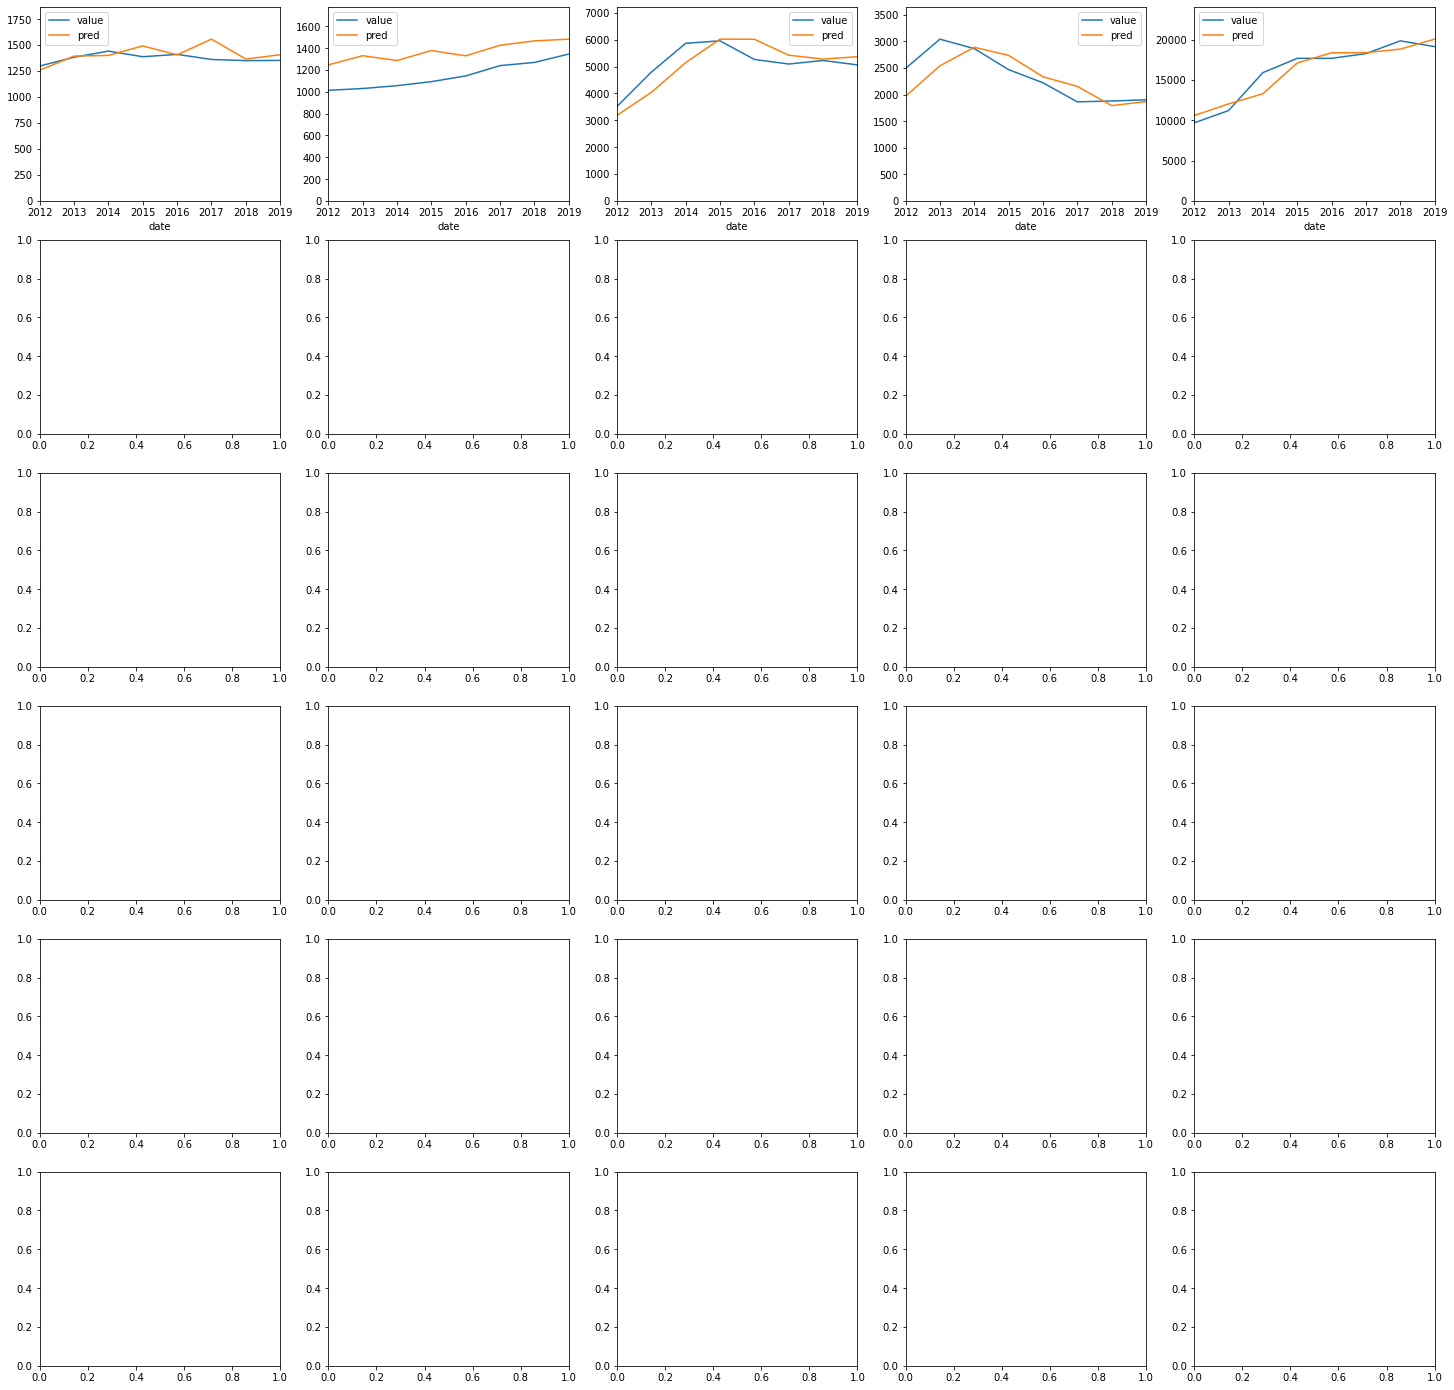

In [9]:
features = ["prev1", "prev2_neg"] + keyword_ids + dummy_cols

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.Lasso(positive=True)
params = {"normalize": [True, False], "alpha": [0.0, 0.01, 0.1, 1.0, 10.0]}
tuner = model_selection.GridSearchCV(reg_unfitted, params, scoring="neg_root_mean_squared_error")

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).to_string())



LASSO Coefficients:
prev1      0.919591
prev2      0.063866
2        -14.362870
10       -17.459829
11        65.310587
12        16.360930
14       -60.023016
15       -50.733659
16        45.509903
17       -70.271793
18         0.000000
19        69.984889
20        13.978489
21        -8.833953
22        33.365881
24       -33.625613
26        34.804016
28        44.175409
32         3.073552
33       -64.169735
37       119.269482
38      -217.676071
39         3.645200
41       -20.258502
42        -6.285648
43        27.905624
44        13.580633
48        29.563305
49       -99.431312
51        36.058404
52       -32.877103
54       -43.870525
55       -50.517295
56        -2.192262
57         5.789216
58        50.535298
59        49.405437
60       -81.726862
112       -7.881788
113      -53.760974
114      -63.079597
115      -19.185725
117      -37.660259
118      -14.441591
119       64.937377
121       69.685151
122      -24.270360
123        8.973833
124       66.597248


,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,test_r2
0,0.222070,0.007529,-0.577027,-1259.326726,0.824688
1,0.011097,0.006127,-0.467883,-906.600190,0.936110
2,0.016501,0.007747,-0.158876,-1304.681391,0.957232
3,0.014390,0.007050,-0.242414,-696.936574,0.985989
4,0.009058,0.007101,-0.356316,-1129.219215,0.965381


Mean CV score:


fit_time                                      0.054623
score_time                                    0.007111
test_neg_mean_absolute_percentage_error      -0.360503
test_neg_root_mean_squared_error          -1059.352819
test_r2                                       0.933880
dtype: float64

OOS score:


neg_mean_absolute_percentage_error      -1.037401
neg_root_mean_squared_error          -2292.399750
r2                                       0.891994
dtype: float64

1442.25
1346.0
5958.75
3044.340051330111
19848.166666666668


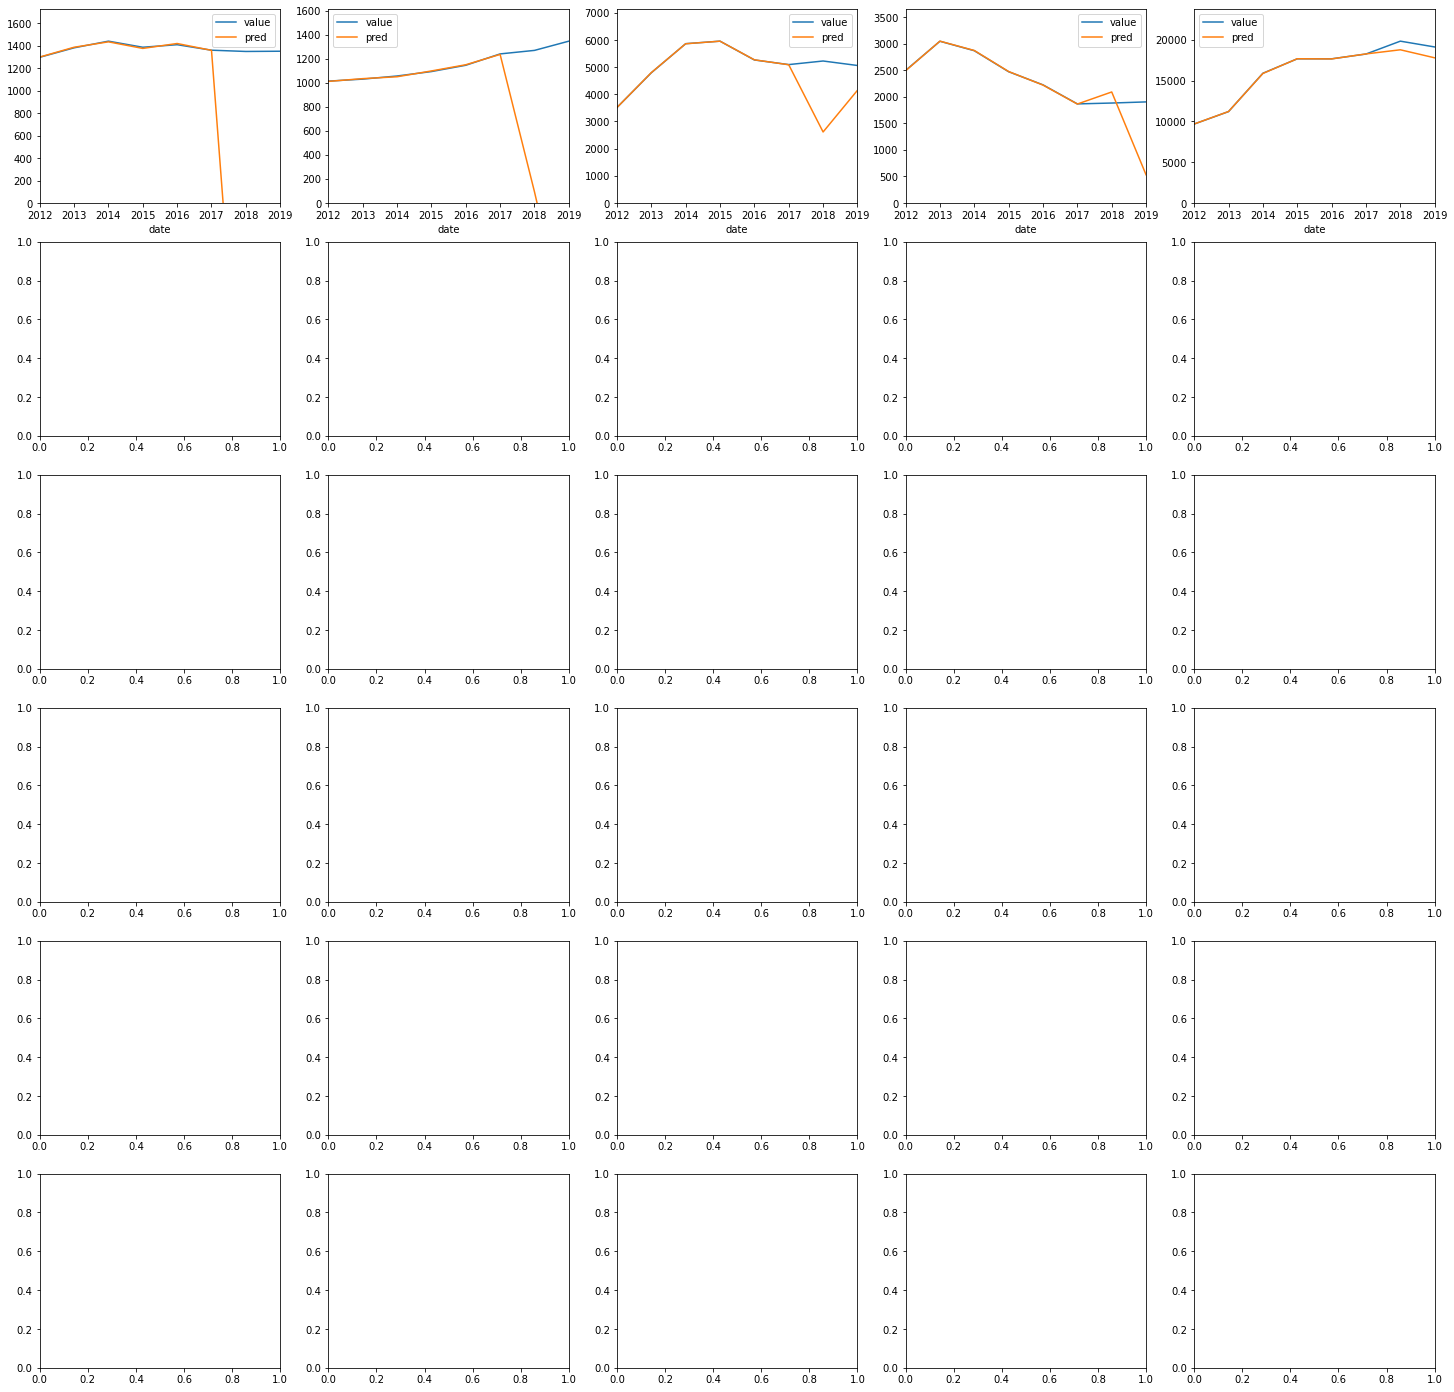

In [10]:
features = ["prev1", "prev2"] + keyword_ids + dummy_cols

reg = linear_model.Lasso()

reg.fit(x_train[features], y_train)

lasso_coefs = reg.coef_

print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])


# feature selection for additional regressors
# tf_1 = "passthrough"
# tf_2 = feature_selection.SelectKBest(feature_selection.f_regression, k=5)
# # tf_2 = feature_selection.SelectFromModel(
# #     linear_model.Lasso(normalize=True, alpha=20, positive=True)
# # )
# tf_3 = "passthrough"
# ct = compose.make_column_transformer(
#     (tf_1, ["prev1", "prev2"]), (tf_2, keyword_ids), (tf_3, dummy_cols)
# )

# reg = pipeline.make_pipeline(
#     ct,
#     linear_model.LinearRegression(),
#     # feature_selection.SequentialFeatureSelector(linear_model.LinearRegression(normalize=True), n_features_to_select=50),
#     # linear_model.LinearRegression(normalize=True),
# )
# reg = linear_model.Lasso(positive=True, alpha=0)
# reg = feature_selection.(linear_model.LinearRegression(), n_features_to_select=50, direction='forward')
# reg = linear_model.LinearRegression(positive=True).fit(x_train, y_train)
# reg = RandomForestRegressor().fit(x_train, y_train)

# reg.score(x_test, y_test)
# reg.fit(x_train, y_train)
# print(reg.coef_)
# df_pred
# print(y.to_numpy())
